In [2]:
#importing libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [4]:
#reading in data
train_x = pd.read_csv("train_Xhw5.csv")
train_y = pd.read_csv("train_yhw5.csv")
test_x = pd.read_csv("test_xhw5.csv")

In [70]:
#understanding the columns, shape and size
print(train_x.head())
print(train_y.head())
print(test_x.head())
print(train_x.shape)  
print(train_y.shape)  
print(test_x.shape)


       Material  D1  D2  D3       D4        D5  D6  D7  D8  D9  ...  D124  \
0        O4V1Y1   8  39  31  15.6667  10.22220   8  12  87  75  ...   0.0   
1  Al1Ba2Cu2F11   9  56  47  17.6250  12.43750   9   9  93  84  ...   0.0   
2      Li2O2Pd1   3  46  43  13.6000  12.96000   3   1  87  86  ...   0.0   
3  Br2Cl2Cu1Rb2  17  37  20  29.5714   7.34694  17   4  95  91  ...   0.0   
4       Al1K1O2   8  19  11  12.0000   4.00000   8   3  87  84  ...   0.0   

   D125  D126  D127  D128  D129     D130      D131  D132    Id  
0   0.0   0.0    12   229   217   78.500   88.6667    12  8683  
1   0.0   0.0    15   229   214   81.125   90.9219    15  8788  
2   0.0   0.0    12   229   217  141.400  103.5200    12  5144  
3   0.0   0.0    64   229   165  134.143   80.1633    64  9593  
4   0.0   0.0    12   229   217  119.500  107.5000    12  2027  

[5 rows x 134 columns]
     Egap    Id
0  2.8121  8683
1  2.5128  8788
2  1.9510  5144
3  1.0099  9593
4  2.9344  2027
     Material  D1  D2  D3  

In [6]:
#dripping Material column from train and test data
train_x = train_x.drop(columns=['Material'])  
test_x = test_x.drop(columns=['Material'])
# Egap is the response label
train_y = train_y['Egap']

In [8]:
#scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_x)  # Fit on training data and transform it
X_test_scaled = scaler.transform(test_x) 


In [10]:
#data split 
X_train, X_val, y_train, y_val = train_test_split(X_scaled, train_y, test_size=0.2, random_state=42)

In [78]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=0.1),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [143]:

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    results[name] = mae
    print(f"{name} MAE: {mae}")
    results[name] = mse
    print(f"{name} MSE: {mse}")

Linear Regression MAE: 0.8443327707079658
Linear Regression MSE: 1.1706185776276894
Lasso Regression MAE: 0.9251357709837279
Lasso Regression MSE: 1.3903003368354376
Ridge Regression MAE: 0.8417677271342272
Ridge Regression MSE: 1.1657986554719022
XGBoost MAE: 0.5878672003237105
XGBoost MSE: 0.7092304353674681
Gradient Boosting MAE: 0.7111350208456336
Gradient Boosting MSE: 0.8584652417156873


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

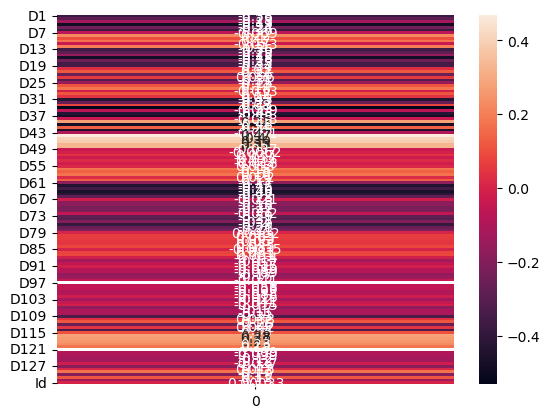

In [82]:
#checking to see correlation to drop features that are highly correlated 
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_scaled, columns=train_x.columns).corrwith(train_y)
sns.heatmap(corr_matrix.to_frame(), annot=True)


In [94]:
#hyperparameter tuning for XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


In [95]:
#searching for the best parameters
xgb_search = RandomizedSearchCV(
    xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_iter=50, random_state=42
)
xgb_search.fit(X_train, y_train)

print(f"Best Params: {xgb_search.best_params_}")
best_xgb_model = xgb_search.best_estimator_

Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [96]:
#fitting the best parameters to get predictions
best_xgb_model.fit(X_train, y_train)
y_pred = best_xgb_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Best XGBoost Model MAE: {mae}")
mse = mean_squared_error(y_val, y_pred)
print(f"Best XGBoost Model MSE: {mse}")

Best XGBoost Model MAE: 0.5549465772928792
Best XGBoost Model MSE: 0.649517652028373


In [100]:
y_test_pred = best_xgb_model.predict(X_test_scaled)

In [106]:
#submission file 1
submission = pd.DataFrame({
    'Id': test_x['Id'], 
    'Egap': y_test_pred  
})
submission.to_csv('submission.csv', index=False)

In [108]:
import optuna

In [187]:
#hyperparameter tuning with Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
        'lambda': trial.suggest_float('lambda', 0.1, 1.0),
        'alpha': trial.suggest_float('alpha', 0.1, 1.0),
        'random_state': 42
    }
    model = XGBRegressor(**param)
    score = -cross_val_score(model, X_scaled, train_y, scoring='neg_mean_absolute_error', cv=5).mean()
    return score


In [189]:
#optimization of hyperparameters, miniminzing MAE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_params)

[I 2024-12-03 15:32:46,058] A new study created in memory with name: no-name-b0618904-7a38-4b9a-bd5a-d1e435e608b2
[I 2024-12-03 15:32:47,365] Trial 0 finished with value: 0.6317514959547232 and parameters: {'n_estimators': 66, 'max_depth': 6, 'learning_rate': 0.06674542600429924, 'subsample': 0.9998003252146811, 'colsample_bytree': 0.8810815745585864, 'gamma': 0.3184383003735184, 'min_child_weight': 14, 'lambda': 0.35090086845608726, 'alpha': 0.9177420549323626}. Best is trial 0 with value: 0.6317514959547232.
[I 2024-12-03 15:32:49,118] Trial 1 finished with value: 0.6965466528092676 and parameters: {'n_estimators': 57, 'max_depth': 7, 'learning_rate': 0.034267127464872975, 'subsample': 0.7583031920951325, 'colsample_bytree': 0.8735301115217449, 'gamma': 0.32369212110233303, 'min_child_weight': 10, 'lambda': 0.43827703784121796, 'alpha': 0.6070712490534053}. Best is trial 0 with value: 0.6317514959547232.
[I 2024-12-03 15:32:51,048] Trial 2 finished with value: 0.7472502462009869 and 

Best hyperparameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.07564746681806053, 'subsample': 0.8764478952925598, 'colsample_bytree': 0.7879062139403303, 'gamma': 0.17251929387249917, 'min_child_weight': 8, 'lambda': 0.8131145440844598, 'alpha': 0.10168495892085595}


In [191]:
# Best hyperparameters from Optuna
best_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'max_depth': 9,
    'learning_rate': 0.07564746681806053,
    'subsample': 0.8764478952925598,
    'colsample_bytree': 0.7879062139403303,
    'gamma': 0.17251929387249917,
    'min_child_weight': 8, 
    'lambda': 0.8131145440844598,
    'alpha': 0.10168495892085595,
    'random_state': 42
}

# Initialize the XGBoost model with the best hyperparameters
final_model = XGBRegressor(**best_params)

# Train the model on the full training data
final_model.fit(X_scaled, train_y)


XGBRegressor(alpha=0.10168495892085595, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7879062139403303, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.17251929387249917,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.8131145440844598,
             learning_rate=0.07564746681806053, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [193]:
cv_scores = cross_val_score(final_model, X_scaled, train_y, cv=10, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE: {-cv_scores.mean()}")

Cross-validation MSE: 0.5822600977914455


In [194]:
# Make predictions on the test data
final_predictions = final_model.predict(X_test_scaled)




In [197]:
submission_df = pd.DataFrame({'Id': test_x['Id'], 'Egap': final_predictions})


submission_df.to_csv('final_predictions.csv', index=False)

print("Submission file created: final_predictions.csv")


Submission file created: final_predictions.csv
